HyDEを用いたベクター検索システム

## 初期設定、準備

ライブラリのインストール

In [ ]:
# パッケージのインストール
!pip install -U langchain langgraph langchain_openai langchainhub tavily-python
!pip install openai

In [28]:
!pip install mecab-python3 janome

   ---------------------------------------- 0.0/501.4 kB ? eta -:--:--
    --------------------------------------- 10.2/501.4 kB ? eta -:--:--
   --- ----------------------------------- 41.0/501.4 kB 487.6 kB/s eta 0:00:01
   --------- ------------------------------ 122.9/501.4 kB 1.0 MB/s eta 0:00:01
   ---------------------------------------- 501.4/501.4 kB 3.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/19.7 MB ? eta -:--:--
    --------------------------------------- 0.3/19.7 MB 9.9 MB/s eta 0:00:02
   - -------------------------------------- 0.7/19.7 MB 8.8 MB/s eta 0:00:03
   -- ------------------------------------- 1.3/19.7 MB 10.4 MB/s eta 0:00:02
   --- ------------------------------------ 1.9/19.7 MB 11.2 MB/s eta 0:00:02
   ----- ---------------------------------- 2.6/19.7 MB 12.0 MB/s eta 0:00:02
   ------ --------------------------------- 3.4/19.7 MB 12.9 MB/s eta 0:00:02
   -------- ------------------------------- 4.3/19.7 MB 13.7 MB/s eta 0:00:02
   

環境設定

In [1]:
import os

new_path = r"C:/Users/iput Hata Sakuto/AppData/Roaming/nltk_data/corpora/stopwords"
current_path = os.environ.get("PATH", "")

# 追加するパスを既存のPATHに追加
os.environ["PATH"] = new_path + ";" + current_path

In [2]:
import os
import openai
# OpenAIに関する環境変数
openai.api_key = os.environ["OPENAI_API_KEY"]

# 出力先のパス
out_path = "C:/Users/iput Hata Sakuto/cuda-11.8/提出/ベースライン/out_put"

# txtデータのパス
txt_path = "C:/Users/iput Hata Sakuto/cuda-11.8/提出/ベースライン/Iput_data.txt"

## langchain

In [3]:
from langchain_openai import OpenAI
from langchain_community.embeddings import OpenAIEmbeddings
from langchain.chains import HypotheticalDocumentEmbedder
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

### ChatGPTとlangchainの連携に関する設定

In [4]:
# カスタムプロンプトの準備
prompt_template = """質問に回答する文章を日本語で書いてください
質問: {question}
回答:"""
prompt = PromptTemplate(input_variables=["question"], template=prompt_template)
llm_chain = LLMChain(llm=OpenAI(temperature=0), prompt=prompt)

HyDE用のプロンプトを用意

In [5]:
# カスタムプロンプトのHypotheticalDocumentEmbedderの準備
embeddings = HypotheticalDocumentEmbedder(
    llm_chain=llm_chain, 
    base_embeddings=OpenAIEmbeddings(), 
)

c:\ProgramData\anaconda3\envs\pyspark-cuda118\lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.1.0 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


自作データを取り込む

In [6]:
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import FAISS
from PyPDF2 import PdfReader
import re
import pandas as pd

# 取り込む対象のtxtファイル先
output_filepath = txt_path


データをchunkingする

In [ ]:
"""
#使用データがPDFの場合、以下を実行

# PDFデータの文字データを取得
def extract_text_from_pdf(filepath):
    with open(filepath, "rb") as file:
        reader = PdfReader(file)
        text = ""
        for page_num in range(len(reader.pages)):
            page = reader.pages[page_num]
            text += page.extract_text()
    return text
# 取得データをテキストデータとして保存
def write_text_to_txt(text, output_filepath):
    with open(output_filepath, "w", encoding="utf-8") as file:
        file.write(text)

#実行文
text_data = extract_text_from_pdf(file_path)
#print(text_data)
write_text_to_txt(text_data, output_filepath)


# 対象のコードはここまで
"""
"""
#langchainの機能を使う場合
# ドキュメントの読み込み
with open(output_filepath) as f:
    read_txt = f.read()
text_splitter = CharacterTextSplitter(
    chunk_size=300, 
    chunk_overlap=0, 
    separator="\n"
)
texts = text_splitter.split_text(read_txt) # ＜ー 今後の対象データをtextsに変更する必要あり
print(len(texts))
print(texts)
"""


In [82]:
#今回は自身でchunkingの上手い手法が実現できなかったため、以下を使用
import pandas as pd

chunk_data = []

# テキストデータを読み込む
with open(output_filepath, "r", encoding="utf-8") as file:
    data_text = file.read()

# 各行を"---------------------------------"で分割
data_list = data_text.split('---------------------------------')

# データフレームに変換
data_df = pd.DataFrame(data_list, columns=['chunk'])
# data_dfの各カラムから'\n'を削除
data_df['chunk'] = data_df['chunk'].str.replace('\n', '')

# 結果の表示
#print(data_df)

In [83]:
print(data_df['chunk'][1])

"""
出力）55年ぶりに国がつくった新しい大学制度によって生まれた、職業に直結した教育を行う専門職大学。プロフェッショナルになるために必要な知識と理論、そして実践的なスキルを身につけることができます。卒業時には専門職の「学位」が取得できます。東京国際工科専門職大学では、「プロフェッショナル」とは単に専門職に従事する人というだけではなく、その専門職における高い「職能」と「意識」を持ち、新しいイノベーションを生み出す人材を指しています。
"""

55年ぶりに国がつくった新しい大学制度によって生まれた、職業に直結した教育を行う専門職大学。プロフェッショナルになるために必要な知識と理論、そして実践的なスキルを身につけることができます。卒業時には専門職の「学位」が取得できます。東京国際工科専門職大学では、「プロフェッショナル」とは単に専門職に従事する人というだけではなく、その専門職における高い「職能」と「意識」を持ち、新しいイノベーションを生み出す人材を指しています。


'\n出力）55年ぶりに国がつくった新しい大学制度によって生まれた、職業に直結した教育を行う専門職大学。プロフェッショナルになるために必要な知識と理論、そして実践的なスキルを身につけることができます。卒業時には専門職の「学位」が取得できます。東京国際工科専門職大学では、「プロフェッショナル」とは単に専門職に従事する人というだけではなく、その専門職における高い「職能」と「意識」を持ち、新しいイノベーションを生み出す人材を指しています。\n'

## In / Out層の作成

検索用データベースの作成

(ベクターストアを使いたかったが、予算が無いため今回はエクセル)

In [8]:
import pandas as pd

output_filename = out_path+'/database.xlsx'
#data_df.to_excel(output_filename, index=False)

※ 今回はエクセルに各チャンクのラベルをエクセルに書きこみ、事前に割り振った

In [54]:
import pandas as pd

input_filename = out_path+'/database.xlsx'

data_df = pd.read_excel(input_filename)
print(data_df)

                                                chunk                    label
0   現代社会の課題は多様な要素が複雑に絡み合い、しかも常に変化しています。その解決には、単一の専...                       使命
1   55年ぶりに国がつくった新しい大学制度によって生まれた、職業に直結した教育を行う専門職大学。...                    専門職大学
2   学びが行き届く 「少人数教育」原則40人以下で行う少人数授業が、専門職大学の特長。本学ではさ...                       特徴
3   実践を学べる「実務家教員」 教員の４割以上は企業等で実務を経験した「実務家教員」特に本学では...                       特徴
4   ビジネスの最前線「企業内実習」 一般的な大学で行われている短期の就業体験・インターンシップと...                       特徴
5   授業全体での「実習・実技の割合」理論と実践の双方を重視するため、卒業に必要な単位のうち、1/...                       特徴
6   ビジネスの現場で培う高度な実践力 産業界との連携が強く、ビジネスの実情に即して授業内容の改善...                       特徴
7   工科学部・情報工学科 AI戦略コース 人工知能の理論から、実装のためのプログラミング技術まで...                      コース
8   自動車の「自動運転」や過去の検索キーワードを元に候補をあげる「予測変換」の事例のように、ビッ...                       育成
9   目指せる将来像 AIエンジニア（システム開発、ソフトウェア開発等） ITコンサルタント デー...                       将来
10                             授与される学位は情報工学士(専門職)である。                       学位
11                                       情報工学科の４年間の学

質問内容のゼロショット分類

-> label_dataはチャンクのラベルに対応する

In [79]:
from transformers import pipeline

# 分類器を初期化します。
classifier = pipeline('zero-shot-classification')

# 分類するテキストとカテゴリを定義します。
query = input("質問：")# <- ユーザーの質問 （クエリ）
label_data = ['参考', '学位', 'コース','専門職大学','特徴','将来',"3年","使命",
              #["専門職大学","使命"],["学び","1年"],["学び","2年"],["学び","3年"],["学び","4年"],
              #["授業","デザインエンジニアリング概論"],["授業","ソリューション開発"],["授業","人工知能システム"],["授業","深層学習"]
             ]

# テキストを分類します。
result = classifier(query, label_data)
#print(result)

# 最もスコアの高かったラベルを取得
max_score_index = result['scores'].index(max(result['scores']))
predict_label = result['labels'][max_score_index]

print("Predicted Label:", predict_label)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


Predicted Label: 将来


分類に基づくchunkデータの収集

In [80]:
# combine_txtを初期化
combine_txt = []

# data_dfの各行に対してループを回す
for index, row in data_df.iterrows():
    # "label"がpredict_labelの要素のいずれかと一致する場合、"chunk"の値をcombine_txtに追加
    if row["label"] == predict_label:
        combine_txt.append(row["chunk"])

# combine_txtがリストである場合、それを結合して1つの文字列にする
result_text = ' '.join(combine_txt)

# 結果の表示
print(result_text)


目指せる将来像 AIエンジニア（システム開発、ソフトウェア開発等） ITコンサルタント データアナリスト 企業（IT系、製造メーカー、自動車メーカー、総合商社、金融等） 官公庁…をはじめ、分野を超えて次世代産業を担う新しい人材を目指せます。


In [ ]:
"""
# combine_txtを初期化
combine_txt = []
# predict_labelとdf_data["label"]が一致する場合、同列のdf_data["chunk"]を取得し、combine_txtに引き渡す
for i, label in enumerate(data_df["label"]):
   if label in predict_label:
       combine_txt.append(data_df["chunk"].iloc[i])

# combine_txtを結合して1つの文字列にする
result_text = ' '.join(combine_txt)

# 結果の表示
print(result_text)
"""

ユーザーの質問に対して類似文書を検索(改善前)

In [81]:
# 類似文章の検索
All_txt = data_df["chunk"]
docsearch = FAISS.from_texts(All_txt, embeddings)
docs = docsearch.similarity_search(query, k=1)
reference_text = docs[0].page_content
print(reference_text)

「卒業研究制作」を中心に、4年間の学びの集大成となる1年間です。ICTが飛躍的に進化するこれからの時代、AI、IoT、ロボットの新しい技術を活用できる人材やデータマネジメントを的確に行える人材の活躍の場は、産業界全体に広がります。本学で、理論と実践、学問と実務の双方を身につけることで、多様化・複雑化する社会の課題を解決し社会が求めるイノベーションを生み出せる「新しい人材」に成長していきます。


ユーザーの質問に対して類似文書を検索(改善後)

-> 当項目にて「質問内容のゼロショット分類」に続き実行する。

In [86]:
#query = ""

# 類似文章の検索
docsearch = FAISS.from_texts(combine_txt, embeddings)
docs = docsearch.similarity_search(query, k=1)
reference_text = docs[0].page_content
print(reference_text)


目指せる将来像 AIエンジニア（システム開発、ソフトウェア開発等） ITコンサルタント データアナリスト 企業（IT系、製造メーカー、自動車メーカー、総合商社、金融等） 官公庁…をはじめ、分野を超えて次世代産業を担う新しい人材を目指せます。


HyDEを用いて文書生成

In [87]:
# 質問応答の実行
from langchain.chains.question_answering import load_qa_chain
chain = load_qa_chain(OpenAI(), chain_type="stuff")
out_put = chain({"input_documents": docs, "question": query}, return_only_outputs=True)
generated_text = out_put.get('output_text', '')
print(generated_text)


学生たちは卒業後、AIエンジニアやITコンサルタント、データアナリストなど、様々な職種を目指すことができます。また、IT系や製造メーカー、自動車メーカー、総合商社、金融など、さまざまな企業や官公庁で活躍することができます。将来の次世代産業を担う新しい人材として、多様な分野で活躍することができるでしょう。


## BLEUスコア

テキストを分かち書きする

In [88]:
from janome.tokenizer import Tokenizer

def text_wakati(text):
    if isinstance(text, list):
        # リストが渡された場合、要素を結合して文字列に変換
        text = ' '.join(text)
    # 分かち書きを行うためのTokenizerオブジェクトを作成します。
    tokenizer = Tokenizer()

    # 文を分かち書きします。
    tokens = tokenizer.tokenize(text)

    # 分かち書きした結果を空白で結合します。
    words = ' '.join([token.surface for token in tokens])
    return words

refer_wakati = text_wakati(reference_text)
print(refer_wakati)
print("-"*30)
gen_wakati = text_wakati(generated_text)
print(gen_wakati)
print("-"*30)
query_wakati = text_wakati(query)
print(query_wakati)

目 指せる 将来 像   AI エンジニア （ システム 開発 、 ソフトウェア 開発 等 ）   IT コンサルタント   データ アナリスト   企業 （ IT 系 、 製造 メーカー 、 自動車 メーカー 、 総合 商社 、 金融 等 ）   官公庁 … を はじめ 、 分野 を 超え て 次世代 産業 を 担う 新しい 人材 を 目指せ ます 。
------------------------------
学生 たち は 卒業 後 、 AI エンジニア や IT コンサルタント 、 データ アナリスト など 、 様々 な 職種 を 目指す こと が でき ます 。 また 、 IT 系 や 製造 メーカー 、 自動車 メーカー 、 総合 商社 、 金融 など 、 さまざま な 企業 や 官公庁 で 活躍 する こと が でき ます 。 将来 の 次世代 産業 を 担う 新しい 人材 として 、 多様 な 分野 で 活躍 する こと が できる でしょ う 。
------------------------------
卒業 後 の 学生 の 将来 について


In [89]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

# BLEUスコアを計算します。
rg_score = sentence_bleu([refer_wakati], gen_wakati)
print('元データと再生成物: ', rg_score)

qr_score = sentence_bleu([query_wakati], refer_wakati)
print('質問と元データ: ', qr_score)

qg_score = sentence_bleu([query_wakati], gen_wakati)
print('質問と再生成物: ', qg_score)

元データと再生成物:  0.4762144802403423
質問と元データ:  0.01735340376625691
質問と再生成物:  0.03427337195589524


## ＜結果＞
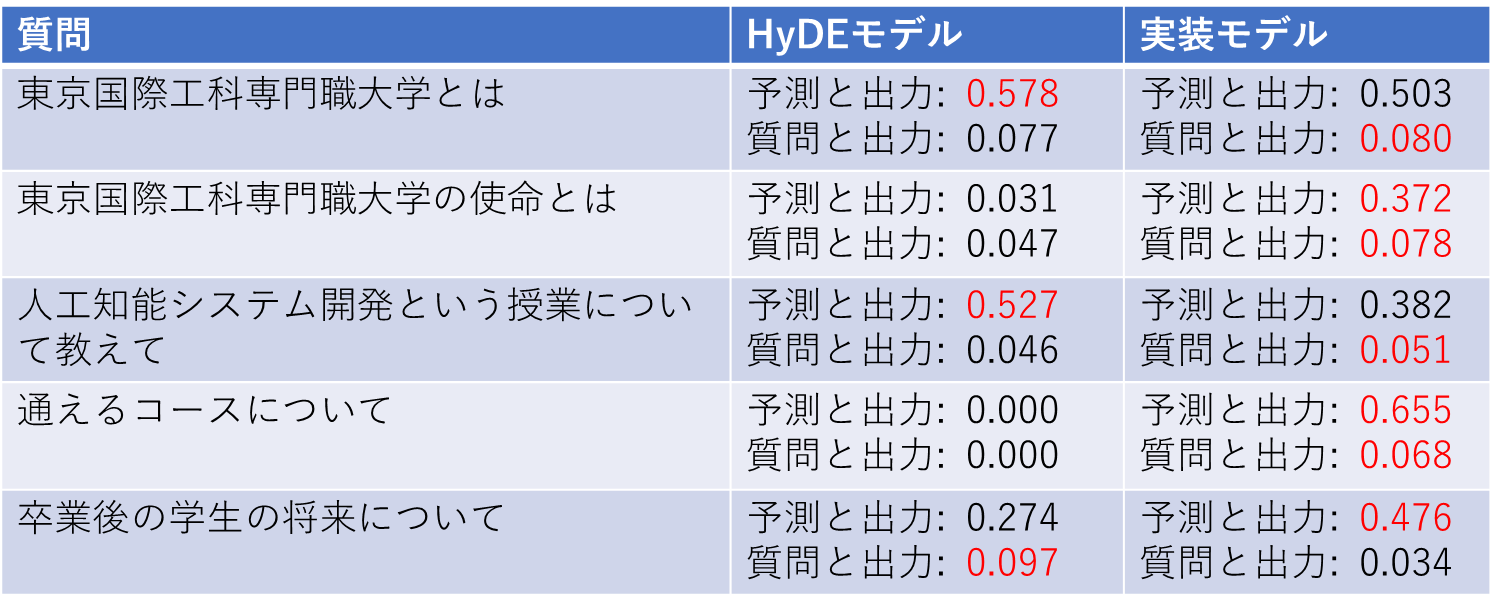

Zero Shotモデルによる検索対象の絞り込みにより関連情報を事前に検索し情報に偏向性を持たせることでHyDEモデルの改善ができると考え、学習ステップに時間をかけず簡易的な実装を試みたが、部分的にHyDEモデル単体よりも元文書と類似性の高い結果を得られたが、かえって低いケースも出てしまった。

---

# 以下は対象外

## 実験用

In [116]:
import pandas as pd
from langchain.chains.question_answering import load_qa_chain
from transformers import pipeline
import nltk
from nltk.translate.bleu_score import sentence_bleu

input_filename = out_path+'/database.xlsx'
data_df = pd.read_excel(input_filename)

def search_byExel(txt):
    docsearch = FAISS.from_texts(txt, embeddings)
    docs = docsearch.similarity_search(query, k=1)
    return docs

def search_byZero():
    docsearch = FAISS.from_texts(combine_txt, embeddings)
    docs = docsearch.similarity_search(query, k=1)
    return docs

def generate_txt(text):
    chain = load_qa_chain(OpenAI(), chain_type="stuff")
    out_put = chain({"input_documents": text, "question": query}, return_only_outputs=True)
    generated_text = out_put.get('output_text', '')
    return generated_text

In [113]:
def remove_separator(text):
    # 指定された文字列を削除
    modified_text = text.replace('---------------------------------', '')
    return modified_text

# テキストデータを読み込む
with open(output_filepath, "r", encoding="utf-8") as file:
    data_text = file.read()
about_text = data_text
# 区切り線を削除したテキストを取得
modified_text = remove_separator(about_text)
# 結果の表示
#print(modified_text)


In [ ]:
# 分類器を初期化します。
classifier = pipeline('zero-shot-classification')


#zero-shot
query = "専門職大学の使命について"# <- ユーザーの質問 （クエリ）
label_data = ['参考', '学位', 'コース','専門職大学','特徴','コース','将来',
              ["専門職大学","使命"],["学び","1年"],["学び","2年"],["学び","3年"],["学び","4年"],
              ["授業","デザインエンジニアリング概論"],["授業","ソリューション開発"],["授業","人工知能システム"],["授業","深層学習"]
             ]
result = classifier(query, label_data)
max_score_index = result['scores'].index(max(result['scores']))
predict_label = result['labels'][max_score_index]
combine_txt = []
for index, row in data_df.iterrows():
    if row["label"] in predict_label:
        combine_txt.append(row["chunk"])
result_text = ' '.join(combine_txt)

#Serch (reference_text)
E_reference_text = search_byExel(modified_text)
p_Er_text = E_reference_text[0].page_content #Blueに使用
Z_reference_text = search_byZero()
p_Ze_text = Z_reference_text[0].page_content #Blueに使用

#generate
E_generate_text = generate_txt(E_reference_text) #Blueに使用
Z_generate_text = generate_txt(Z_reference_text) #Blueに使用

#----------------------------------------------------------------
# wakati
E_refer_wakati = text_wakati(E_reference_text)
E_gen_wakati = text_wakati(E_generate_text)
Z_refer_wakati = text_wakati(Z_reference_text)
Z_gen_wakati = text_wakati(Z_generate_text)
query_wakati = text_wakati(query)

#score
# byExel
E_rg_score = sentence_bleu([E_refer_wakati], E_gen_wakati)
E_qr_score = sentence_bleu([query_wakati], E_refer_wakati)
E_qg_score = sentence_bleu([query_wakati], E_gen_wakati)
print("by Exel:",E_rg_score,",",E_qr_score,",",E_qg_score)
# byZero
Z_rg_score = sentence_bleu([Z_refer_wakati], Z_gen_wakati)
Z_qr_score = sentence_bleu([query_wakati], Z_refer_wakati)
Z_qg_score = sentence_bleu([query_wakati], Z_gen_wakati)
print("by Zero:",Z_rg_score,",",Z_qr_score,",",Z_qg_score)

## chunkingを自動化
-> 卒論レベルのことなので、期間中に実装できず断念

各チャンクデータを要約

In [43]:
summary_chunk = []

for i in range(len(data_df['chunk'])):
   print("要約対象\n",data_df["chunk"][i],"\n")

   chunk_messages = [{
   'role': 'system',
   'content': data_df["chunk"][i]
   }]

   summary_response = openai.chat.completions.create(model="gpt-3.5-turbo",
                                                     messages=chunk_messages,
                                                    )
   summary = summary_response.choices[0].message.content
   summary_chunk.append(summary)
   print(summary)
   
   print("-"*30)

要約対象
 現代社会の課題は多様な要素が複雑に絡み合い、しかも常に変化しています。その解決には、単一の専門分野の知識＜静的な専門知＞だけでは困難です。だからこそ私たちは、既存の諸学問の壁を超えて専門分野を横断し、現場の実践で得られた知見や最新テクノロジーを統合的に駆使した＜動的な創造知＞を目指します。そのために、学生と教員が一体となって探究し、産業界や地域、世界の人々と協働する。理論と実践を武器に新たな価値を創造し、より良い未来を創るために必要な力を共に育む。そして、多様で複雑な社会課題に立ち向かう“Designer in Society（社会とともにあるデザイナー）”を世に送り出す。これが、これからの時代に対応する新大学としての、私たち東京国際工科専門職大学の使命です。 

現代社会の課題はますます複雑化しており、解決には単一の専門分野の知識だけでは不十分です。そのため、私たちは既存の学問の壁を越えて、様々な知識やスキルを統合したアプローチを取る必要があります。

私たちの大学では、学生と教員が一体となって、実践や最新のテクノロジーを活用しながら、探究しています。また、産業界や地域、世界の人々との協働を通じて、理論と実践を結びつけ、新たな価値を創造しています。

これまでの大学とは異なり、「Designer in Society」というコンセプトのもと、社会とともにあるデザイナーを育成することを目指しています。私たちは、デザインの力を活用して、多様で複雑な社会課題に立ち向かうことができる人材を育成することを使命としています。

私たちの目標は、より良い未来を創るために必要な力を備えた人材を育成し、社会へ送り出すことです。これからの時代に求められる新しい大学として、私たちは常に進化し続けるよう努めています。
------------------------------
要約対象
 55年ぶりに国がつくった新しい大学制度によって生まれた、職業に直結した教育を行う専門職大学。プロフェッショナルになるために必要な知識と理論、そして実践的なスキルを身につけることができます。卒業時には専門職の「学位」が取得できます。東京国際工科専門職大学では、「プロフェッショナル」とは単に専門職に従事する人というだけではなく、その専門職における高い「職能」と「意識」を持ち、新しいイノベーショ

In [ ]:
# summary_chunk を data_df に追加
data_df["summary"] = summary_chunk

# 結果の表示
print(data_df)

                                                chunk  \
0   現代社会の課題は多様な要素が複雑に絡み合い、しかも常に変化しています。その解決には、単一の専...   
1   55年ぶりに国がつくった新しい大学制度によって生まれた、職業に直結した教育を行う専門職大学。...   
2   学びが行き届く 「少人数教育」原則40人以下で行う少人数授業が、専門職大学の特長。本学ではさ...   
3   実践を学べる「実務家教員」 教員の４割以上は企業等で実務を経験した「実務家教員」。特に本学で...   
4   ビジネスの最前線「企業内実習」 一般的な大学で行われている短期の就業体験・インターンシップと...   
5   授業全体での「実習・実技の割合」理論と実践の双方を重視するため、卒業に必要な単位のうち、1/...   
6   ビジネスの現場で培う高度な実践力 産業界との連携が強く、ビジネスの実情に即して授業内容の改善...   
7   工科学部・情報工学科 AI戦略コース 人工知能の理論から、実装のためのプログラミング技術まで...   
8                                 授与される学位は 情報工学士(専門職)   
9                                        情報工学科の４年間の学び   
10  １年次体験的な学びからスタートし、ＩＣＴの基本をマスター　― 実践的イントロダクション ― ...   
11  ２年次コース別のカリキュラムスタート　― 「エンジニアリングスキル」を身につける ― コース...   
12  ３年次専門知識・技能のレベルアップ　― 「テクノロジー実践力」と「ビジネスセンス」を磨く ―...   
13  ４年次応用力と総合力を備えた人材へ　― デジタル社会で広がる活躍の場 ― 「卒業研究制作」を...   
14  デザインエンジニアリング概論 “Designer in Society”の核となる、デザイン...   
15  ソリューション開発Ⅰ・Ⅱ 協力企業・団体から提供される実践的な課題をもとに、チームでソリュー...   
16  人工知能システム開発Ⅰ・Ⅱ 2年次前期、3年次前期の実

各summaryデータからキーワード抽出

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from janome.tokenizer import Tokenizer
from collections import Counter

# Custom stop words list
custom_stop_words = ["ある", "する", "です", "など", ...]  # Add more stop words as needed

def extract_top_keyword(text):
    # Janomeを使用して形態素解析を行います。
    janome_parser = Tokenizer()
    tokens = janome_parser.tokenize(text)

    # 形態素解析の結果から名詞を抽出します。
    nouns = [token.surface for token in tokens if '名詞' in token.part_of_speech]

    # Remove custom stop words
    nouns = [word for word in nouns if word not in custom_stop_words]

    # If there are no meaningful words left, return None
    if not nouns:
        return None

    # 文書全体のリストに変換してからTF-IDFを計算
    corpus = [" ".join(nouns)]

    # Use TfidfVectorizer with custom stop words
    vectorizer = TfidfVectorizer(stop_words=custom_stop_words)
    tfidf_matrix = vectorizer.fit_transform(corpus)

    # Check if the vocabulary is empty
    if not vectorizer.vocabulary_:
        return None

    # TF-IDFの値を抽出
    feature_names = vectorizer.get_feature_names_out()
    tfidf_values = tfidf_matrix.toarray()[0]

    # TF-IDFを組み合わせてキーワードを抽出
    tfidf_dict = dict(zip(feature_names, tfidf_values))
    top_keyword = max(tfidf_dict, key=tfidf_dict.get)

    return top_keyword

key_extraction = []

for i in range(len(data_df['chunk'])):
    extraction =  data_df['chunk'][i]

    # 一番重要なキーワードの抽出
    top_keyword = extract_top_keyword(extraction)
    #print("Top Keyword:", top_keyword  )
    #print("-"*30)
    key_extraction.append(top_keyword)

print(key_extraction)

['専門', '専門', '人数', '実務', 'ビジネス', '実技', 'ビジネス', 'ai', 'ai', 'it', '学位', '学び', 'イントロダクション', '理論', 'エンジニアリング', '課題', 'センス', '実務', 'デジタル', '人材', 'エンジニアリング', '製品', 'ソリューション', '企業', 'システム', 'システム', '学習', '技術', 'ac']


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from janome.tokenizer import Tokenizer
from collections import Counter

# Custom stop words list
custom_stop_words = ["ある", "する", "です", "など", ...]  # Add more stop words as needed

def extract_keywords(text):
    # Janomeを使用して形態素解析を行います。
    janome_parser = Tokenizer()
    tokens = janome_parser.tokenize(text)

    # 形態素解析の結果から名詞を抽出します。
    nouns = [token.surface for token in tokens if '名詞' in token.part_of_speech]

    # Remove custom stop words
    nouns = [word for word in nouns if word not in custom_stop_words]

    # If there are no meaningful words left, return an empty list
    if not nouns:
        return []

    return nouns

# すべてのキーワードを格納するリスト
all_keywords = []

for i in range(len(data_df['chunk'])):
    extraction = data_df['chunk'][i]

    # キーワードの抽出
    keywords = extract_keywords(extraction)
    all_keywords.append(keywords)

    # すべてのキーワードを表示
    print(f"Keywords for chunk {i + 1}: {keywords}")
    print("-" * 30)

# すべてのキーワードをフラット化して表示
flat_keywords = [keyword for sublist in all_keywords for keyword in sublist]
print("All Keywords:")
print(flat_keywords)

Keywords for chunk 1: ['現代', '社会', '課題', '多様', '要素', '複雑', '変化', '解決', '単一', '専門', '分野', '知識', '静的', '専門', '知', '困難', '私', 'たち', '既存', '諸', '学問', '壁', '専門', '分野', '横断', '現場', '実践', '知見', '最新', 'テクノロジー', '統合', '的', '駆使', '動的', '創造', '知', 'ため', '学生', '教員', '一体', '探究', '産業', '界', '地域', '世界', '人々', '協', '働', '理論', '実践', '武器', '新た', '価値', '創造', '未来', 'ため', '必要', '力', '多様', '複雑', '社会', '課題', 'Designer', 'in', 'Society', '社会', 'デザイナー', '世', 'これ', '時代', '対応', '新', '大学', '私', 'たち', '東京', '国際', '工科', '専門', '職', '大学', '使命']
------------------------------
Keywords for chunk 2: ['55', '年', 'ぶり', '国', '大学', '制度', '職業', '直結', '教育', '専門', '職', '大学', 'プロフェッショナル', 'ため', '必要', '知識', '理論', '実践', '的', 'スキル', '身', 'こと', '卒業', '時', '専門', '職', '学位', '取得', '東京', '国際', '工科', '専門', '職', '大学', 'プロフェッショナル', '専門', '職', '従事', '人', '専門', '職', '職能', '意識', 'イノベーション', '人材']
------------------------------
Keywords for chunk 3: ['学び', '少', '人数', '教育', '原則', '40', '人', '以下', '少', '人数', '授業', '専門', '職', '大学', '特長', '本学', '学

In [30]:
print(all_keywords)

[['現代', '社会', '課題', '多様', '要素', '複雑', '変化', '解決', '単一', '専門', '分野', '知識', '静的', '専門', '知', '困難', '私', 'たち', '既存', '諸', '学問', '壁', '専門', '分野', '横断', '現場', '実践', '知見', '最新', 'テクノロジー', '統合', '的', '駆使', '動的', '創造', '知', 'ため', '学生', '教員', '一体', '探究', '産業', '界', '地域', '世界', '人々', '協', '働', '理論', '実践', '武器', '新た', '価値', '創造', '未来', 'ため', '必要', '力', '多様', '複雑', '社会', '課題', 'Designer', 'in', 'Society', '社会', 'デザイナー', '世', 'これ', '時代', '対応', '新', '大学', '私', 'たち', '東京', '国際', '工科', '専門', '職', '大学', '使命'], ['55', '年', 'ぶり', '国', '大学', '制度', '職業', '直結', '教育', '専門', '職', '大学', 'プロフェッショナル', 'ため', '必要', '知識', '理論', '実践', '的', 'スキル', '身', 'こと', '卒業', '時', '専門', '職', '学位', '取得', '東京', '国際', '工科', '専門', '職', '大学', 'プロフェッショナル', '専門', '職', '従事', '人', '専門', '職', '職能', '意識', 'イノベーション', '人材'], ['学び', '少', '人数', '教育', '原則', '40', '人', '以下', '少', '人数', '授業', '専門', '職', '大学', '特長', '本学', '学生', '10', '人', '1', 'グループ', '担当', '教員', '完全', '担任', '制度', '採用', '学修', '進路', '指導', '細やか', 'サポート', '対話', '議論', '学び', '環境'], ['実

In [26]:
# key_extraction を data_df に追加
data_df["key_extraction"] = key_extraction

# 結果の表示
print(data_df)

                                                chunk key_extraction
0   現代社会の課題は多様な要素が複雑に絡み合い、しかも常に変化しています。その解決には、単一の専...             専門
1   55年ぶりに国がつくった新しい大学制度によって生まれた、職業に直結した教育を行う専門職大学。...             専門
2   学びが行き届く 「少人数教育」原則40人以下で行う少人数授業が、専門職大学の特長。本学ではさ...             人数
3   実践を学べる「実務家教員」 教員の４割以上は企業等で実務を経験した「実務家教員」特に本学では...             実務
4   ビジネスの最前線「企業内実習」 一般的な大学で行われている短期の就業体験・インターンシップと...           ビジネス
5   授業全体での「実習・実技の割合」理論と実践の双方を重視するため、卒業に必要な単位のうち、1/...             実技
6   ビジネスの現場で培う高度な実践力 産業界との連携が強く、ビジネスの実情に即して授業内容の改善...           ビジネス
7   工科学部・情報工学科 AI戦略コース 人工知能の理論から、実装のためのプログラミング技術まで...             ai
8   自動車の「自動運転」や過去の検索キーワードを元に候補をあげる「予測変換」の事例のように、ビッ...             ai
9   目指せる将来像 AIエンジニア（システム開発、ソフトウェア開発等） ITコンサルタント デー...             it
10                             授与される学位は情報工学士(専門職)である。             学位
11                                       情報工学科の４年間の学び             学び
12     １年次体験的な学びからスタートし、ＩＣＴの基本をマスター　― 実践的イントロダクション ―       イントロダクション
13  従来の大学教育では一般的に理論を先に学びますが、「実践を重視

各chunkデータの固有表現の抽出

In [17]:
import spacy

# spaCyの日本語モデルをロードします。
nlp = spacy.load("ja_ginza")

def extract_highest_named_entity(text):
   # モデルに解析対象のテキストを渡します。
   doc = nlp(text)
   # 固有表現の抽出
   entities = [(ent.text, ent.label_) for ent in doc.ents]
    # 抽出された固有表現があれば最も高い確信度のものを返す
   if entities:
      highest_entity = max(entities, key=lambda x: nlp(x[0]).similarity(nlp(x[0])))
      return highest_entity
   else:
      return None

#以下、内容
ner_data = []

for i in range(len(data_df)):
   #print(texts[i])
   #print("-"*20)
   base_data = data_df["chunk"][i]

   # 最も高い確信度の固有表現を抽出
   result = extract_highest_named_entity(base_data)
   # None の場合に "データ" を代入
   if result is None:
      result = ("データ", "未知のタイプ")
   
   """
   #固有表現の中身を確認
   if result:
      print("Highest Named Entity:", result[0])
      print("Entity Type:", result[1])
   else:
      print("No named entities found.")
   """
   ner_data.append(result[0])

print(ner_data)

['学生', '55年ぶり', '40人以下', '実務家教員', '16週間以上', '1/3以上', 'データ', '工科学部・情報工学科', '自動運転', 'ITコンサルタント', '情報工学士', '情報工学科', '１', '1年次前期', '２', '課題解決型学習', '３', '2年次', '４', '4年間', 'デザインエンジニアリング概論', 'Designer in Society', 'Ⅰ・Ⅱ', '1つのシステム', '人工知能システム開発', '2', 'データ', 'ニューラルネットワーク', 'データ']


In [27]:
import spacy

# spaCyの日本語モデルをロードします。
nlp = spacy.load("ja_ginza")

def extract_named_entities(text):
    # モデルに解析対象のテキストを渡します。
    doc = nlp(text)
    # 固有表現の抽出
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

#以下、内容
ner_data = []

for i in range(len(data_df)):
    base_data = data_df["chunk"][i]

    # 固有表現の抽出
    result = extract_named_entities(base_data)
    
    # 抽出された固有表現を全て表示
    if result:
        print(f"Named Entities for chunk {i + 1}:")
        for entity, entity_type in result:
            print(f"Entity: {entity}, Type: {entity_type}")
        print("-" * 30)
    else:
        print(f"No named entities found for chunk {i + 1}")
        print("-" * 30)

    ner_data.extend(result)

print(ner_data)

Named Entities for chunk 1:
Entity: 学生, Type: Position_Vocation
Entity: 教員, Type: Position_Vocation
Entity: Designer in Society, Type: Product_Other
Entity: デザイナー, Type: Position_Vocation
Entity: 東京国際, Type: School
------------------------------
Named Entities for chunk 2:
Entity: 55年ぶり, Type: Period_Year
Entity: 東京国際, Type: School
------------------------------
Named Entities for chunk 3:
Entity: 40人以下, Type: N_Person
Entity: 専門職大学, Type: Doctrine_Method_Other
Entity: 学生, Type: Position_Vocation
Entity: 約10人, Type: N_Person
Entity: 1グループ, Type: N_Organization
Entity: 担当教員, Type: Position_Vocation
Entity: 完全担任制度, Type: Doctrine_Method_Other
------------------------------
Named Entities for chunk 4:
Entity: 実務家教員, Type: Position_Vocation
Entity: 教員, Type: Position_Vocation
Entity: ４割以上, Type: Percent
Entity: 実務家教員, Type: Position_Vocation
Entity: エキスパート, Type: Clothing
------------------------------
Named Entities for chunk 5:
Entity: 16週間以上, Type: Period_Week
Entity: 600時間以上, Type: Per

In [ ]:
# ner_data を data_df に追加
data_df["ner"] = ner_data

# 結果の表示
print(data_df)